# Estimating the Loss of Medieval Literature with an Unseen Species model from Ecodiversity

In [1]:
import numpy as np
np.random.seed(76451)
import scipy.stats as stats
from scipy.special import gammaln
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
from functools import partial
import seaborn as sb
from tqdm import tqdm_notebook


Bad key "text.kerning_factor" on line 4 in
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## The loss of works

### Data

Read the data on Middle Dutch chivalric epics (*Middelnederlandse ridderepiek*), mainly drawn from Kienhorst's acclaimed 1988 repertory:

In [2]:
df = pd.read_excel('../data/mnl_chiv.xlsx', header=None)
df.columns = ('work', 'sigle', 'signature')
df.head()

,work,sigle,signature
0,Aiol (1),H1,"Leiden, UB, BPL 1049; Brussel, KB, IV 816"
1,Aiol (2),H2,"Breda, Arch. Begijnhof, z.s."
2,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge...","München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders geesten,H3,"Gent, UB, 2749,6"
4,Alexanders geesten,H4,"Leiden, UB, Ltk. 1196"


Turn this tabular data into abundance data:

In [3]:
types = df.groupby('work').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='# works')
types['# witnesses'] = types.index
types

,# works,# witnesses
1,45,1
2,13,2
3,6,3
4,2,4
5,4,5
6,1,6
7,1,7
10,2,10
17,1,17


In [4]:
cnts = df.groupby('work').size().values # ignore zero
cnts

array([ 1,  1,  1,  5,  2,  1,  2,  1,  1,  3,  1,  1,  2,  1,  1,  2,  1,
        1,  1,  2,  1,  1,  1,  1,  1, 17,  1,  4,  1,  7,  1,  1,  1,  1,
        2, 10,  4,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  5,
        5,  3,  2,  3,  1,  1,  3, 10,  2,  5,  1,  2,  2,  1,  1,  2,  1,
        1,  2,  1,  1,  1,  1,  3])

### Estimators

#### Chao1

In [5]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

In [6]:
chao_richness(cnts)

152.41824044219254

In [7]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([fn(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

In [8]:
def chao_estimate(x, n_iter=10000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=chao_richness, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [9]:
lci_pro, uci_pro, chao1_pro, pro = chao_estimate(cnts)
print(f'Chao1: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Chao1: 152.42 CI(110.46 - 225.73)


#### Jackknife

In [10]:
def dbinom(x, size, prob):
    d = stats.binom(size, prob).pmf(x)
    return 1 if np.isnan(d) else d


def jackknife(data, k=5, conf=0.95):
    k0, k = k, min(len(np.unique(data)) - 1, 10)
    n = np.bincount(data)[1:]
    n = np.array((np.arange(1, n.shape[0] + 1), n)).T
    total = n[:, 1].sum()
    gene = np.zeros((k + 1, 5))
    gene[0, 0] = total
    for i in range(1, k + 1):
        gene[i, 0] = total
        gene[i, 3] = total
        for j in range(1, i + 1):
            gene[i, 0] = (
                gene[i, 0] +
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) * n[j - 1, 1])
            gene[i, 3] = gene[i, 3] + (-1)**(j + 1) * 2**i * dbinom(
                j, i, 0.5) * n[j - 1, 1] * np.prod(np.arange(1, j + 1))
        gene[i, 1] = -gene[i, 0]
        for j in range(1, i + 1):
            gene[i, 1] = (gene[i, 1] + (
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) + 1)**2 * n[j - 1, 1])
        gene[i, 1] = np.sqrt(gene[i, 1] + n[i:, 1].sum())
    if k > 1:
        for i in range(2, k + 1):
            gene[i - 1, 2] = -(gene[i, 0] - gene[i - 1, 0])**2 / (total - 1)
            for j in range(1, i):
                gene[i - 1, 2] = gene[i - 1, 2] + (
                    (-1)**(j + 1) * 2**(i) * dbinom(j, i, 0.5) -
                    (-1)**(j + 1) * 2**(i - 1) * dbinom(j, i - 1, 0.5)
                )**2 * n[j - 1, 1] * total / (total - 1)
            gene[i - 1, 2] = np.sqrt(gene[i - 1, 2] + n[i - 1, 1] * total /
                                     (total - 1))
            gene[i - 1, 4] = (gene[i, 0] - gene[i - 1, 0]) / gene[i - 1, 2]
    coe = stats.norm().ppf(1 - (1 - 0.95) / 2)
    x = gene[1:k + 1, 4] < coe
    if x.sum() == 0:
        jackest = gene[k, 0]
        sej = gene[k, 1]
        order = 1
    else:
        indicator = np.arange(1, k + 1)
        jackest = gene[indicator[x][0], 0]
        sej = gene[indicator[x][0], 1]
        order = np.arange(1, k + 2)[indicator[x][0]] - 1
    if k0 <= order:
        jackest = gene[k0, 0]
        sej = gene[k0, 1]
        order = k0
    return jackest, sej, order, jackest - coe * sej, jackest + coe * sej

In [11]:
jk, sej, order, jk_lci, jk_uci = jackknife(cnts)
print(f'Jackknife (@order={order}): {jk:.2f} CI({jk_lci:.2f} - {jk_uci:.2f})')

Jackknife (@order=3): 177.00 CI(127.81 - 226.19)


#### Egghe & Proot

In [12]:
def ep(counts, alpha=500):
    ft = np.bincount(counts)[1:]
    S = ft.sum()
    P1, P2 = (counts == 1).sum(), (counts == 2).sum()
    P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
    S_lost = S * (P0 / (1 - P0))
    S_lost = S + S_lost
    return S_lost if not np.isinf(S_lost) else np.nan

In [13]:
ep_score = ep(cnts)

In [14]:
def ep_estimate(x, n_iter=10000, conf=0.95):
    pro = ep(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=ep, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [15]:
lci_pro, uci_pro, ep_pro, pro = chao_estimate(cnts)
print(f'Egghe & Proot: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Egghe & Proot: 152.42 CI(109.32 - 230.17)


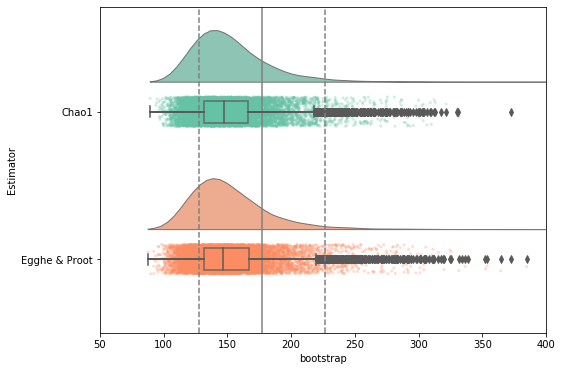

In [16]:
d = list([(x, 'Chao1') for x in chao1_pro])
d += list([(x, 'Egghe & Proot') for x in ep_pro])
bt = pd.DataFrame(d, columns=('bootstrap', 'Estimator'))
bt

fig, ax = plt.subplots(figsize=(8, 6))
pt.RainCloud(
    data=bt, x="Estimator", y="bootstrap", ax=ax, 
    orient="h", alpha=.8, bw=.2, rain_alpha=.3,
);

ax.axvline(jk, c='grey')
ax.axvline(jk_lci, c='grey', ls='--')
ax.axvline(jk_uci, c='grey', ls='--');
ax.set_xlim([50, 400]);

## The loss of documents

In [17]:
def minsample(x):
    n = x.sum()
    x = x[x > 0]
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    h = lambda x: 2 * f1 * (1 + x)
    v = lambda x: np.exp(x * (2 * f2 / f1))
    
    search_space = np.linspace(0, 100, 10000)
    hs = np.array(h(search_space))
    vs = np.array(v(search_space))
    diffs = np.abs(hs - vs)
    x_ast = search_space[diffs.argmin()]
    return n * x_ast

In [18]:
ms = minsample(cnts)
print('Estimate:', 100 / (minsample(cnts) / cnts.sum()), '% of documents survived')

Estimate: 8.1557911908646 % of documents survived


In [19]:
def minsample_estimate(x, n_iter=1000, conf=0.95):
    pro = minsample(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=minsample, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [20]:
lci, uci, bt_msample, ms = minsample_estimate(cnts)
print(f'Minimum sampling: {ms:.2f} CI({lci:.2f} - {uci:.2f})')

Minimum sampling: 2047.62 CI(1033.38 - 4073.37)


## Species Accumulation curve, with miminum sampling effort included

In [21]:
def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [22]:
num_docs = len(cnts) + int(minsample(cnts)) # n + m
lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(cnts, fn=partial(rarefaction_extrapolation, max_steps=num_docs), n_iter=50)

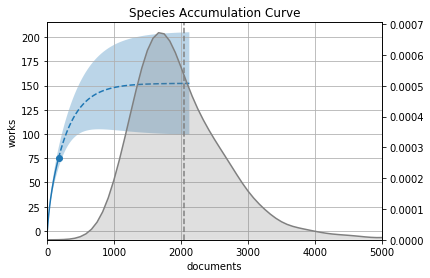

In [23]:
steps = np.arange(1, num_docs)
interpolated = np.arange(1, num_docs) < cnts.sum()
plt.plot(steps[interpolated], Dq[interpolated], color='C0')
plt.plot(cnts.sum(), Dq[cnts.sum() - 1], 'o')
plt.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
plt.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
plt.grid()
plt.axvline(ms, ls='--', c='grey')
plt.xlabel('documents')
plt.ylabel('works')
plt.title('Species Accumulation Curve')
ax2 = plt.gca().twinx()
sb.kdeplot(bt_msample, ax=ax2, color='grey', shade=True)
plt.xlim([0, 5000]);

## Simulations

### Loss of works

In [49]:
def rmse(pred, true):
    return np.sqrt((pred - true) ** 2)

total_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
sample_sizes = [5, 10, 15, 25, 30, 35]
n_experiments = 30
alpha = 150

results = []
for _ in range(n_experiments):
    for total_size in total_sizes:
        for sample_size in sample_sizes:
            # create a corpus with n works, each having between 1 and 100 copies
            corpus = np.repeat(np.arange(total_size), np.clip(stats.dlaplace(0.01, loc=150).rvs(total_size), 1, 100).astype(int))
            _, corpus_counts = np.unique(corpus, return_counts=True)
            # sample `sample_size` items from the corpus, assuming that editions with more
            # copies have a higher chance of survival
            sample = np.random.choice(
                total_size, size=sample_size, p=corpus_counts / corpus_counts.sum())
            # compute the counts
            _, counts = np.unique(sample, return_counts=True)
            # estimate
            results.append({'total size': total_size, 's+ample size': sample_size,
                            'RMSE': rmse(ep(counts, alpha), total_size), 'estimator': 'Egghe & Proot'})
            results.append({'total size': total_size, 'sample size': sample_size,
                            'RMSE': rmse(jackknife(counts)[0], total_size), 'estimator': 'Jackknife'})
            results.append({'total size': total_size, 'sample size': sample_size,
                                'RMSE': rmse(chao_richness(counts), total_size), 'estimator': 'Chao & Jost'})
S_df = pd.DataFrame(results)

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [50]:
S_df

,total size,s+ample size,RMSE,estimator,sample size
0,100,5.0,NaN,Egghe & Proot,NaN
1,100,NaN,95.000000,Jackknife,5.0
2,100,NaN,87.000000,Chao & Jost,5.0
3,100,10.0,59.521607,Egghe & Proot,NaN
4,100,NaN,83.000000,Jackknife,10.0
...,...,...,...,...,...
5395,1000,NaN,970.000000,Jackknife,30.0
5396,1000,NaN,549.500000,Chao & Jost,30.0
5397,1000,35.0,425.453851,Egghe & Proot,NaN
5398,1000,NaN,933.000000,Jackknife,35.0


In [52]:
import pandas as pd

s_pool = 150

def sample_lnorm(S, n_sims, cv=1):
    mu = n_sims / s_pool
    sd = mu * cv
    sigma = np.sqrt(np.log(sd ** 2 / mu ** 2 + 1))
    mu = np.log(mu) - sigma ** 2 / 2
    pop = np.random.lognormal(mean=mu, sigma=sigma, size=S)
    _, pop = np.unique(np.random.choice(S, size=n_sims, p=pop / pop.sum()), return_counts=True)
    return pop

pop = sample_lnorm(200, 600)
chao_richness(pop)

182.30831018518518

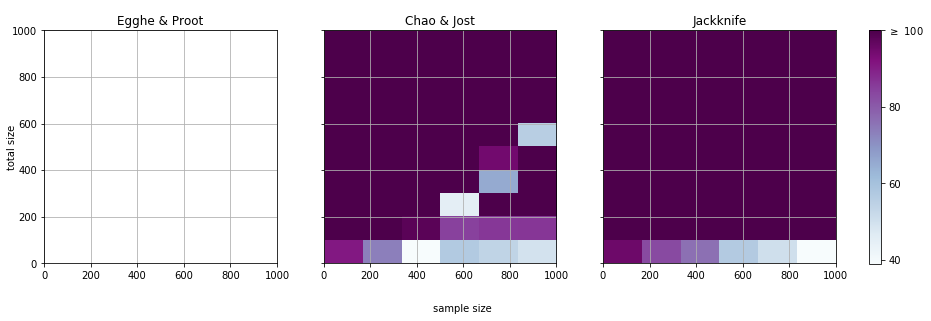

In [53]:
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True, sharex=True)
for i, estimator in enumerate(('Egghe & Proot', 'Chao & Jost', 'Jackknife')):
    r = S_df[S_df['estimator'] == estimator].groupby(
                ['total size', 'sample size']).median().reset_index().pivot(
            "total size", "sample size", "RMSE")
    im = axes[i].imshow(r[::-1], cmap='BuPu', vmax=100, extent=(0, 1000, 0, 1000), 
                   origin='upper')
    axes[i].set_title(estimator)
    axes[i].grid(b=None)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.014, pad=0.04,
                    ticks=[0, 20, 40, 60, 80, 100])
cbar.ax.set_yticklabels(['0', '20', '40', '60', '80', '$\geq$ 100'])
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("total size")
plt.xlabel("sample size");

# Estimating diversity and entropy profiles of cultural collections

## Diversity Profiles
Diversity measures such as "Richness", "Shannon's Index", and "Simpson's Index" can be used to describe the compositional complexity of cultural assemblages. Richness represents a straightforward measure of diversity as it is simply the number of unique items (or traits) $|T|$ in some collection or population. Shannon's Index is a well-known measure of entropy in a collection, and Simpson's Index describes the probability that two randomly drawn items $x_i$ and $x_j$ belong to the same trait $y_i$. Together, these three commonly used measures capture some important aspects of the compositional complexity of the frequency distribution of assemblages. However, a serious drawback for studying diversity is that the measures are not directly comparable. To illustrate that, consider the following example. 

Suppose we have two collections, $c_1$ and $c_2$. $c_1$ has 500 unique items (each of which occurs only once). $c_2$ consists of 250 items that are also part of $c_1$ and again occur only once:

In [1]:
import numpy as np

c1 = np.ones(500, dtype=np.int)
c2 = np.ones(250, dtype=np.int)

Naturally, the 'richness' of $c_2$ is half that of $c_1$:

In [2]:
def richness(counts):
    return (counts > 0).sum()

richness(c2) == 0.5 * richness(c1)

True

Let's compare this first diversity measurement with one that includes information on trait abundances. First, we'll use Shannon's Index, which we implement as follows:

In [3]:
def shannon_entropy(counts, base=np.e):
    freqs = counts / counts.sum()
    freqs = freqs[freqs.nonzero()]
    return -(freqs * np.log(freqs)).sum() / np.log(base)

In [4]:
H1 = shannon_entropy(c1)
H2 = shannon_entropy(c2)

As we would expect, community 1 has the maximum number of Shannon diversity, as it consists of all available traits:

In [5]:
np.isclose(np.log(richness(c1)), H1)

True

Some numerical differences aside, it is. Perhaps contrary to our expectation, the Shannon index of $c_2$ is _not_ half that of $c_1$:

In [6]:
np.isclose(np.log(richness(c2)), 0.5 * H1)

False

That's because the relationship between richness and Shannon diversity is non-linear, as illustrated by the following plot:

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


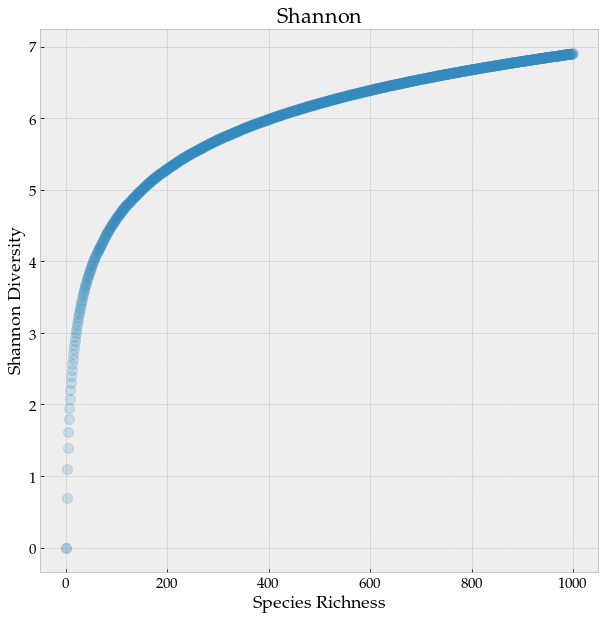

In [80]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 15})
rc('text', usetex=True)
plt.style.use('bmh')


m = np.zeros((1000, 2))

for i in range(1000):
    c = np.ones(i)
    m[i, 0] = i
    m[i, 1] = shannon_entropy(c)

plt.figure(figsize=(10, 10))
plt.plot(m[:, 0], m[:, 1], 'o', markersize=10, alpha=0.2)
plt.xlabel("Species Richness")
plt.ylabel("Shannon Diversity")
plt.title("Shannon");

While theoretically correct, this may seem counterintuitive. When thinking about diversity, our (or at least my) natural interpretation is closer to that of richness. To account for the non-linearity, Jost (2010) suggests to convert the measures to effective numbers or "Hill Numbers". To convert Shannon Diversity into its corresponding effective number, we take its exponent. When doing that, we see that the Shannon Diversity now behaves like Richness:

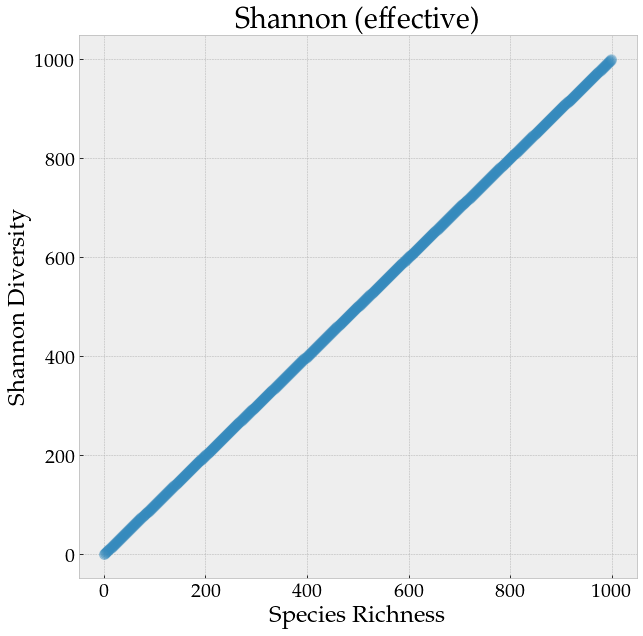

In [9]:
m = np.zeros((1000, 2))

for i in range(1000):
    c = np.ones(i)
    m[i, 0] = i
    m[i, 1] = np.exp(shannon_entropy(c))

plt.figure(figsize=(10, 10))
plt.plot(m[:, 0], m[:, 1], 'o', alpha=0.2, markersize=10)
plt.xlabel("Species Richness")
plt.ylabel("Shannon Diversity")
plt.title("Shannon (effective)");

The same issue applies to Simpson diversity, which also holds a non-linear relationship with richness:

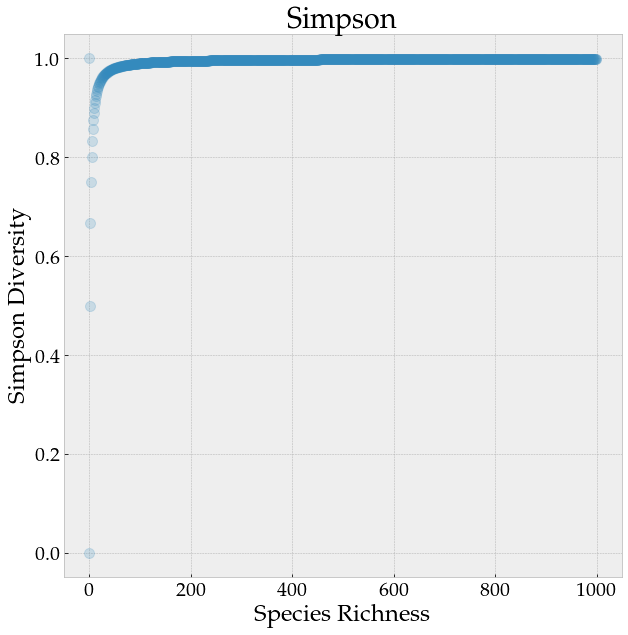

In [10]:
def simpson_diversity(counts):
    return 1 - ((counts / counts.sum()) ** 2).sum()

m = np.zeros((1000, 2))
for i in range(1000):
    c = np.ones(i)
    m[i, 0] = i
    m[i, 1] = simpson_diversity(c)
    
plt.figure(figsize=(10, 10))
plt.plot(m[:, 0], m[:, 1], 'o', alpha=0.2, markersize=10)
plt.xlabel("Species Richness")
plt.ylabel("Simpson Diversity")
plt.title("Simpson");

After converting it to effective numbers ($1 / (1 - S(c))$), we obtain the same linear relationship as before:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


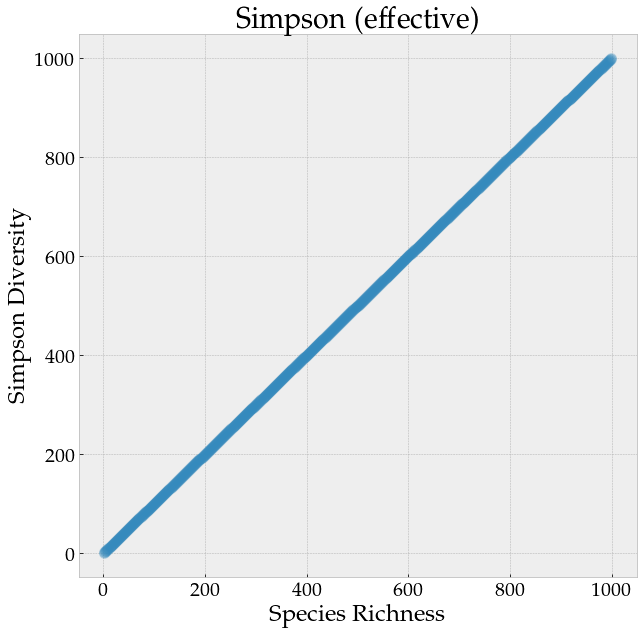

In [11]:
m = np.zeros((1000, 2))
for i in range(1000):
    c = np.ones(i)
    m[i, 0] = i
    m[i, 1] = 1 / (1 - simpson_diversity(c))
    
plt.figure(figsize=(10, 10))
plt.plot(m[:, 0], m[:, 1], 'o', alpha=0.2, markersize=10)
plt.xlabel("Species Richness")
plt.ylabel("Simpson Diversity")
plt.title("Simpson (effective)");

Both Shannon diversity and Simpson diversity are special cases of entropy. The can be derived from the following general equation of entropy:

$$^qD(p) = \Big(\sum^S_{i=1} p^q_i \Big)^{1 / (1 - q)}$$

The parameter $q$ here defines the sensitivity to rare traits, with low values favoring rare traits and higher values more common ones. It can be shown that Shannon Diversity is of order $q = 1$, and Simpson diversity of order $q = 3$. Richness, then, is of order $q = 0$. Using this formula, we can now compute diversity along a continuum of diversity orders $q$. By doing so, we obtain a so-called "Diversity Profile", which allows us to measure and visualize the contributions of rare and more common traits in a population at high granularity. To compute such a profile, we implement the following little function:

In [12]:
def diversity_profile(c):
    x = np.arange(0, 5, 0.11)
    m = np.zeros((x.shape[0], 2))
    n = c.sum()
    for i, q in enumerate(x):
        m[i, 0] = q
        m[i, 1] = np.sum(((c / n) ** q)) ** (1 / (1 - q))
    return m

Of course, with a collection consisting solely of traits occurring once, the diversity profile isn't that interesting:

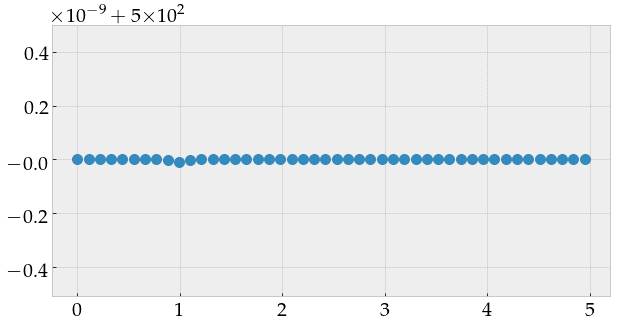

In [13]:
dp = diversity_profile(c1)

plt.figure(figsize=(10, 5))
plt.plot(dp[:, 0], dp[:, 1], 'o', markersize=10);

It becomes more interesting, when we we traits with different frequencies of observation:

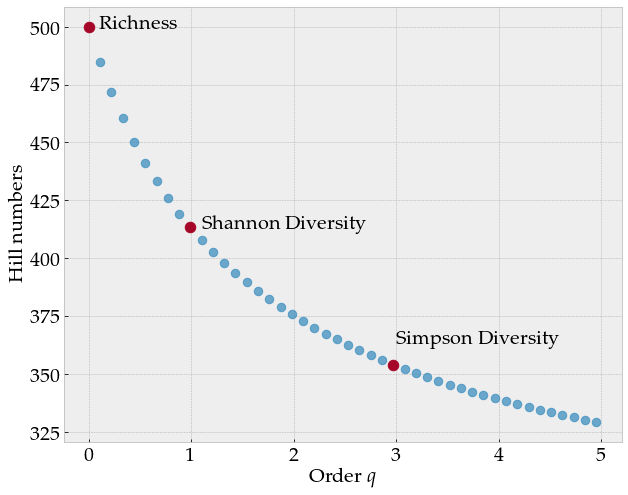

In [14]:
BLUE, RED = '#348ABD', '#A60628'

fig, ax = plt.subplots(figsize=(10, 8))
c3 = np.random.randint(1000, size=500)
dp = diversity_profile(c3)
ax.plot(dp[:, 0], dp[:, 1], 'o', markersize=8.5, color=BLUE, alpha=0.7)
ax.annotate("Richness", xy=(0.1, 499), size=20)
ax.plot(dp[0, 0], dp[0, 1], 'o', c=RED, markersize=10.5)
ax.annotate("Shannon Diversity", xy=(1.1, np.exp(shannon_entropy(c3))), size=20)
ax.plot(dp[9, 0], dp[9, 1], 'o', c=RED, markersize=10.5)
ax.annotate("Simpson Diversity", xy=(3, 1 / ( 1 - simpson_diversity(c3)) - 12), size=20)
ax.plot(dp[27, 0], dp[27, 1], 'o', c=RED, markersize=10.5)
ax.set_xlabel("Order $q$", size=20)
ax.set_ylabel("Hill numbers", size=20);
plt.savefig('../reports/figures/div_profile.pdf')

Using a Zipf distribution with $\alpha = 2$, we obtain a sharper profile:

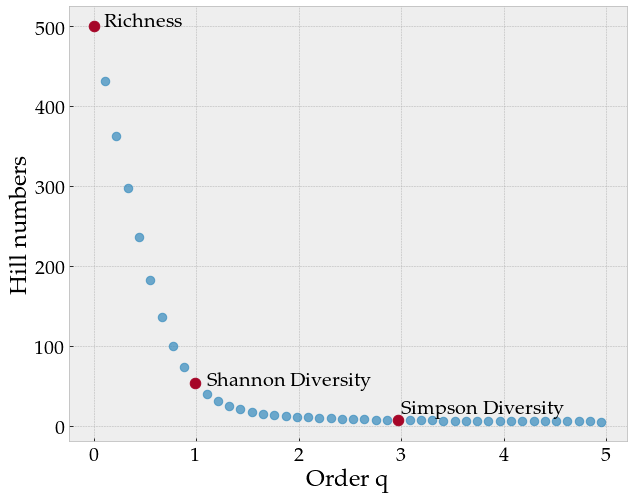

In [15]:
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(10, 8))
c4 = stats.zipf(2.).rvs(500)
dp4 = diversity_profile(c4)
ax.plot(dp4[:, 0], dp4[:, 1], 'o', alpha=0.7, markersize=8.5, color=BLUE)
ax.annotate("Richness", xy=(0.1, 500), size=20)
ax.plot(dp4[0, 0], dp4[0, 1], 'o', c=RED, markersize=10.5)
ax.annotate("Shannon Diversity", xy=(1.1, np.exp(shannon_entropy(c4))), size=20)
ax.plot(dp4[9, 0], dp4[9, 1], 'o', c=RED, markersize=10.5)
ax.annotate("Simpson Diversity", xy=(3, 1 / (1 - simpson_diversity(c4)) + 5), size=20)
ax.plot(dp4[27, 0], dp4[27, 1], 'o', c=RED, markersize=10.5)
ax.set_xlabel("Order q")
ax.set_ylabel("Hill numbers");
plt.savefig('../reports/figures/div_profile_zipf.pdf')

And just as easy, we apply it to some real-world data. Here, I compute the empirical diversity profile for melodies in the Dutch Song Database observed during 1550-1750:

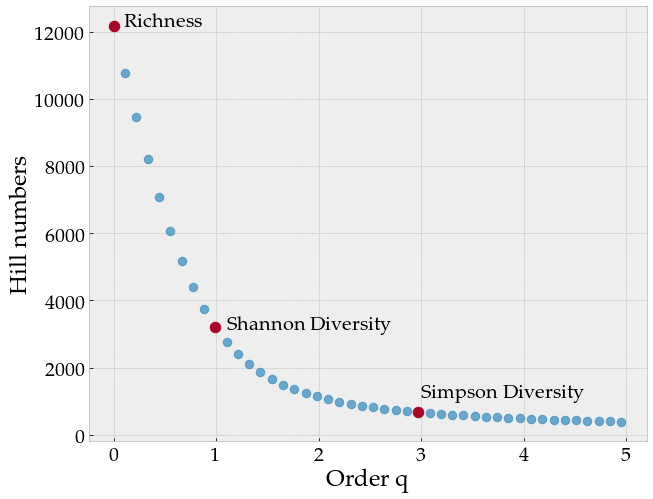

In [16]:
import pandas as pd
df = pd.read_csv('../data/processed/nlb.y1.1550.1750.csv', index_col=0).sum(0).values

fig, ax = plt.subplots(figsize=(10, 8))
dp = diversity_profile(df)
ax.plot(dp[:, 0], dp[:, 1], 'o', markersize=8.5, color=BLUE, alpha=0.7)
ax.annotate("Richness", xy=(0.1, df.shape[0]), size=20)
ax.plot(dp[0, 0], dp[0, 1], 'o', c=RED, markersize=10.5)
ax.annotate("Shannon Diversity", xy=(1.1, np.exp(shannon_entropy(df))), size=20)
ax.plot(dp[9, 0], dp[9, 1], 'o', c=RED, markersize=10.5)
ax.annotate("Simpson Diversity", xy=(3, 1 / (1 - simpson_diversity(df))), size=20)
ax.plot(dp[27, 0], dp[27, 1], 'o', c=RED, markersize=10.5)
ax.set_xlabel("Order q")
ax.set_ylabel("Hill numbers");
plt.savefig('../reports/figures/div_profile_nlb.pdf')

## Measuring the unmeasurable: diversity profiles for unseen data

Cultural collections are rarely complete. As such, the empirical diversity profiles computed in the previous section underestimate the true profile as a result of undersampling. Chao & Jost (2015) propose a bias-correcting estimator for diversity profiles, which allows us "to obtain accurate, continuous, low-bias diversity and entropy profiles with focus on low orders of q $(0 \leq q \leq 3)$". Chao & Jost arrive at a new formulation of Hill Numbers which enables us to deal with undersampling:

$$^qD = \Bigg(\sum^\infty_{k=0} \binom{q - 1}{k} (-1)^k \Delta(k)\Bigg)^{1 / (1 - q)}$$

where $\Delta(k)$ is defined as:

$$\Delta(k) = \frac{S(k + 1) - S(k)}{(k + 1) - k} = \sum^S_{i = 1} p_i(1 - p_i)^k$$

and $S(k)$ is a function of sample size $k$:

$$S(k) = \sum^S_{i = 1} 1 - (1 - p_i)^k = S - \sum^S_{i = 1} (1 - p_i)^k$$

For $k < n$ (i.e. smaller than the sample size), we can compute the empirical diversity profile without bias. Chao & Jost split the equation into two parts: one for the empirical profile computation and one for dealing with out of sample estimation:

$$^qD = \Bigg(\sum^{n = 1}_{k=0} \binom{q - 1}{k} (-1)^k \Delta(k) + \sum^\infty_{k=n} \binom{q - 1}{k} (-1)^k \Delta(k)\Bigg)^{1 / (1 - q)}$$

Following Chao, Wang & Jost (2013), they use slope estimators to approximate the second sum. The script to compute this estimated diversity profile can be found in `src/models/chao.py`. We'll first test the diversity estimator on some theoretical frequency models to see to what extent it can recover or estimate the true diversity profiles. We generate a community from a lognormal distribution. The original S = 200 and we sample 600 individuals.

In [17]:
%run ../src/chao.py
%run ../src/plots.py

In [61]:
import pandas as pd

s_pool = 150

def sample_lnorm(S, n_sims, cv=1):
    mu = n_sims / s_pool
    sd = mu * cv
    sigma = np.sqrt(np.log(sd ** 2 / mu ** 2 + 1))
    mu = np.log(mu) - sigma ** 2 / 2
    pop = np.random.lognormal(mean=mu, sigma=sigma, size=S)
    _, pop = np.unique(np.random.choice(S, size=n_sims, p=pop / pop.sum()), return_counts=True)
    return pop

pop = sample_lnorm(200, 600)
chao_richness(pop)

199.99786324786325

In [62]:
pd.Series(pop).describe()

count    168.000000
mean       3.571429
std        3.159571
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       17.000000
dtype: float64

The function `estimate` in `chao.py` allows us to estimate the full diversity profile over arbitrary values of $q$. The function returns the empirical maximum likelihood estimate, as well as the Chao & Jost diversity profile with bootstrapped confidence intervals:

In [63]:
mle, pro = estimate(pop, n_iter=1000, n_jobs=4)

100%|██████████| 1000/1000 [00:17<00:00, 57.54it/s]


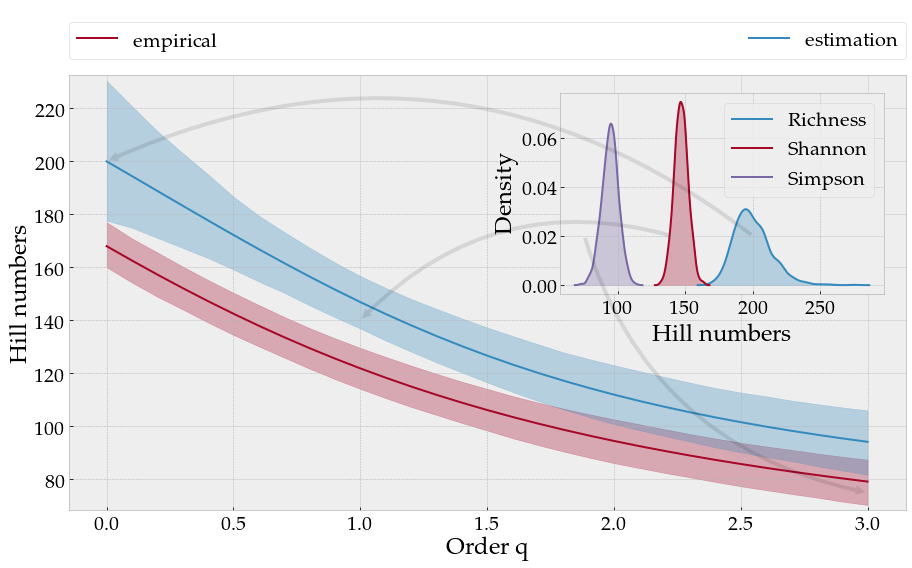

In [64]:
%run ../src/plots.py
import matplotlib

fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
left, bottom, width, height = [0.58, 0.5, 0.3, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
plot_estimates(mle, pro, ax=ax1)
plot_densities(pro[-2], ax=ax2)

def connect_plots(x1, y1, x2, y2):
    ax0tr = ax1.transData # Axis 0 -> Display
    ax1tr = ax2.transData # Axis 1 -> Display
    figtr = fig.transFigure.inverted() # Display -> Figure
    # 2. Transform arrow start point from axis 0 to figure coordinates
    ptB = figtr.transform(ax1tr.transform((x1, y1)))
    # 3. Transform arrow end point from axis 1 to figure coordinates
    ptE = figtr.transform(ax0tr.transform((x2, y2)))
    # 4. Create the patch
    arrow = matplotlib.patches.FancyArrowPatch(
        ptB, ptE, transform=fig.transFigure,  # Place arrow in figure coord system
        fc = "black", connectionstyle="arc3,rad=0.3", arrowstyle='simple', alpha = 0.1,
        mutation_scale = 20.
    )
    # 5. Add patch to list of objects to draw onto the figure
    fig.patches.append(arrow)
    
connect_plots(200, 0.02, 0, 200)
connect_plots(140., 0.02, 1., 140.)
connect_plots(75., 0.02, 3., 75.)

plt.savefig('../reports/figures/div_estimation_lnorm.pdf')

## Jackknife

As can be observed, the estimator does a fair job in recovering aspects of the original distribution, such as, for example, the richness diversity. For smaller sample sizes, however, the Chao estimator is known to underestimate the true richness. The unveiled Jackknife estimator, first introduced in Burman & Overton (1979), has been shown to perform better for situations with bad sampling. The Jackknife is a resampling procedure which reduces bias according to the following procedure:

1. Remove one of the observations $i \in {1, 2, \ldots, n}$;
2. Compute the empirical $S$ for the complete sample;
3. Compute an estimate $\hat{S}_{-i}$ for the resampled population;
4. Compute a pseudovalue $\hat{S}_i = nS - (n - 1)\hat{S}_{-i}$;
5. Repeat 1 to 4 for all $i \in {1, 2, \ldots, n}$;
6. Compute the first order Jackknife:

$$J_1 = \frac{1}{n} \sum \hat{S}_i$$

The unveiled Jacknife estimator extends this procedure to artibitrary Jackknife orders (i.e. removing more than 1 observation), and chooses the appropriate order on the basis of the data. An implementation of the Unveiled Jackknife estimator is found in the function `jackknife` in `chao.py`.

## Egghe & Proot (2007)

Egghe & Proot (2007) describe an estimator in the context of lost books. The model they propose is a simple probabilistic model which computes the probability of lost editions $P_0$ as follows:

$$P_0 = \Big(\frac{1}{1 + \frac{2}{a - 1} \frac{P_2}{P_1}}\Big)^\alpha$$

where $P_1$ is the number of editions occuring once, and $P_2$ is the number of editions occuring twice. The parameter $\alpha$ is a constant representing the assumed run of copies of an edition. Below, we will compare the Richness estimates of the Chao estimator, the Jackknife estimator, and Egghe & Proot's estimator for different sample sizes. 

## Estimator Comparison

In [68]:
%run ../src/egghe_proot.py
%run ../src/jackknife.py

from tqdm import tqdm_notebook

q_values = np.arange(0, 3.1, 0.1)
reps, s_pool, cv, alpha = 100, 100, 0.937, 150
sample_sizes = list(range(100, 2100, 100))

results = []
for i, n_sim in enumerate(tqdm_notebook(sample_sizes)):
    for j in range(reps):
        pop = sample_lnorm(s_pool, n_sims=n_sim, cv=cv)
        results.append({'sample size': n_sim, 'S': ep(pop, alpha), 'estimator': 'Egghe \& Proost'})
        results.append({'sample size': n_sim, 'S': jackknife(pop)[0], 'estimator': 'Jackknife'})
        results.append({'sample size': n_sim, 'S': chao_richness(pop), 'estimator': 'Chao \& Jost'})
S_df = pd.DataFrame(results)

/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  S_lost = S * (P0 / (1 - P0))
/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:8: RuntimeWarning: invalid value encountered in long_scalars
  P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
/Users/folgertkarsdorp/Projects/lost_books/src/jackknife.py:38: RuntimeWarning: invalid value encountered in double_scalars
  gene[i - 1, 4] = (gene[i, 0] - gene[i - 1, 0]) / gene[i - 1, 2]


By computing the Root Mean Square Error (RMSE) between estimates and the true Richness (`s_pool`) we can get a sense of which method performs better (on average) for different sample sizes. The following 'rainplot' gives a detailed impression of the performance of the esimators for different sample sizes:

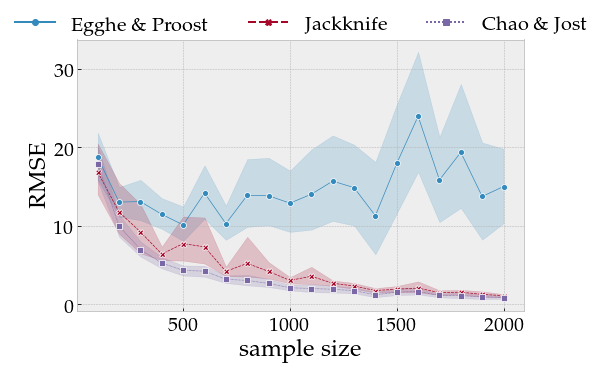

In [69]:
S_df['RMSE'] = np.sqrt((s_pool - S_df['S']) ** 2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='sample size', y='RMSE', hue='estimator', data=S_df, 
             style='estimator', markers=True, linewidth=0.7)

def legend_on_top(ax, ncol, title=None):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles[1:], labels=labels[1:],
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
        loc="upper center",
        ncol=ncol,
        borderaxespad=0.0,
        facecolor="white",
        framealpha=0,
        title=None
    )

legend_on_top(ax, 3)
plt.savefig('../reports/figures/estimator_comparison_rmse.pdf')

We see that as the same size increases, the Chao estimator has an edge. The Egghe & Proot estimator performs worse on all levels and is more variable. This is comfirmed when plotting the raw $\hat{S}$ estimates against the true (horizontal line) $S$:

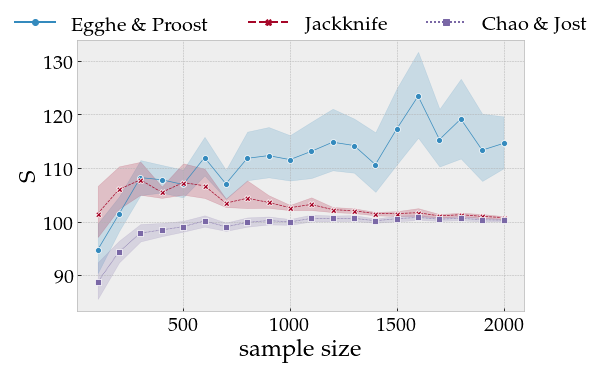

In [71]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='sample size', y='S', hue='estimator', data=S_df, 
             style='estimator', markers=True, linewidth=0.7)
legend_on_top(ax, 3)
plt.savefig('../reports/figures/estimator_comparison_raw.pdf')

## Different sampling strategies

In the previous experiments, we assumed collections follow a lognormal frequency distribution. We will now focus on different kinds of distributions and compare the performance of the different estimators for those samples. Egghe & Proot (2007) describe a simple corpus construction and sampling procedure, in which they create a corpus of $S$ editions, each of which has a run of $\alpha = 150$. They then sample $n$ items from the corpus and try to estimate $S$ on the basis of that sample. Of course, the assumption that $\alpha$ is a constant is a bit problematic, so we'll relax that in a moment, but first, let's replicate their estimator validation technique.

In [76]:
alpha = 150 # assume constant alpha, like in Egghe & Proot (2007)
# experiment with different numbers of editions
edition_sizes = np.arange(250, 10250, 250)
n = 1000 # assume constant sample size, like in Egghe & Proot (2007)
n_experiments = 100

results = []
for i, size in enumerate(tqdm_notebook(edition_sizes, desc='edition size')):
    # create a corpus with n editions, each having a run of alpha
    corpus = np.repeat(np.arange(size), alpha)
    for j in range(n_experiments):
        # sample n items from the corpus
        np.random.shuffle(corpus)
        sample = corpus[:n]
        # compute the counts
        _, counts = np.unique(sample, return_counts=True)
        # estimate
        results.append({'n editions': size, 'S': ep(counts, alpha), 'estimator': 'Egghe \& Proost'})
        results.append({'n editions': size, 'S': jackknife(counts)[0], 'estimator': 'Jackknife'})
        results.append({'n editions': size, 'S': chao_richness(counts), 'estimator': 'Chao \& Jost'})
S_df = pd.DataFrame(results)

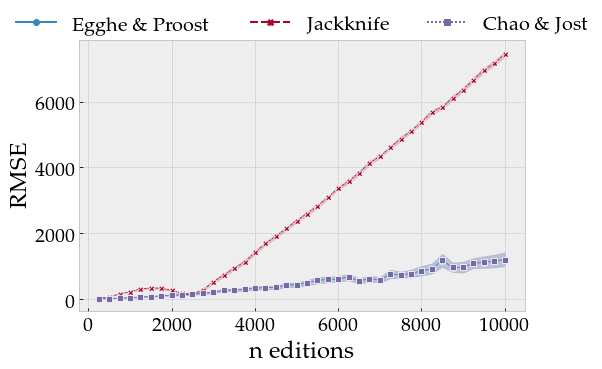

In [77]:
S_df['RMSE'] = np.sqrt((S_df['n editions'] - S_df['S']) ** 2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='n editions', y='RMSE', hue='estimator', data=S_df, 
             style='estimator', markers=True, linewidth=0.7)
legend_on_top(ax, 3)
plt.savefig('../reports/figures/estimator_comparison_constant_alpha.pdf')

Interestingly, we see that the Chao and Egghe & Proot estimators are nearly equivalent in this sampling context (but remember that Chao & Jost is non-parametric). Also, the Jackknife estimator breaks for higher editions numbers $S$. This effect is largely due to the small sample size ($n=1000$). Sampling slightly more documents improves estimation greatly:

In [78]:
alpha = 150 # assume constant alpha, like in Egghe & Proot (2007)
# experiment with different numbers of editions
edition_sizes = np.arange(250, 10250, 250)
n = 10000
n_experiments = 100

results = []
for i, size in enumerate(tqdm_notebook(edition_sizes, desc='edition size')):
    # create a corpus with n editions, each having a run of alpha
    corpus = np.repeat(np.arange(size), alpha)
    for j in range(n_experiments):
        # sample n items from the corpus
        np.random.shuffle(corpus)
        sample = corpus[:n]
        # compute the counts
        _, counts = np.unique(sample, return_counts=True)
        # estimate
        results.append({'n editions': size, 'S': ep(counts, alpha), 'estimator': 'Egghe \& Proost'})
        results.append({'n editions': size, 'S': jackknife(counts)[0], 'estimator': 'Jackknife'})
        results.append({'n editions': size, 'S': chao_richness(counts), 'estimator': 'Chao \& Jost'})
S_df = pd.DataFrame(results)

/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:8: RuntimeWarning: invalid value encountered in long_scalars
  P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
/Users/folgertkarsdorp/Projects/lost_books/src/jackknife.py:38: RuntimeWarning: invalid value encountered in double_scalars
  gene[i - 1, 4] = (gene[i, 0] - gene[i - 1, 0]) / gene[i - 1, 2]
/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  S_lost = S * (P0 / (1 - P0))


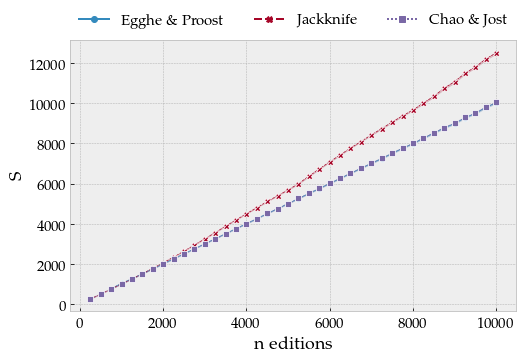

In [82]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='n editions', y='S', hue='estimator', data=S_df, 
             style='estimator', markers=True, linewidth=0.7)
legend_on_top(ax, 3)
plt.savefig('../reports/figures/estimator_comparison_constant_alpha_bigger_sample.pdf')

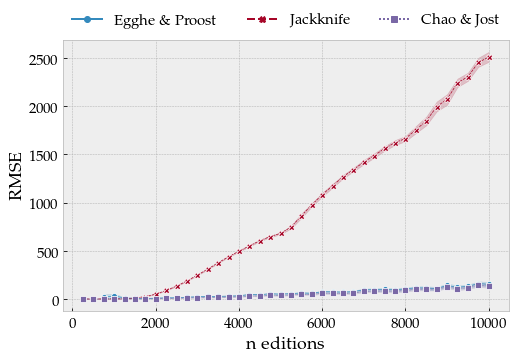

In [83]:
S_df['RMSE'] = np.sqrt((S_df['n editions'] - S_df['S']) ** 2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='n editions', y='RMSE', hue='estimator', data=S_df, 
             style='estimator', markers=True, linewidth=0.7)
legend_on_top(ax, 3)
plt.savefig('../reports/figures/estimator_comparison_constant_alpha_bigger_sample_rmse.pdf')

We see that all estimators perform rather well for $S \leq 2000$. With $S > 2000$, te performance of the Jackknife estimator degrades. The problem here is that the sampling strategy produces very flat distributions, with barely any frequency diffences:

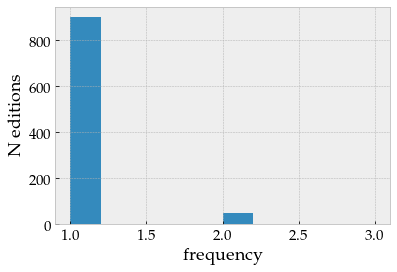

In [84]:
corpus = np.repeat(np.arange(10000), 150)
sample = corpus[np.random.randint(corpus.shape[0], size=1000)]
_, counts = np.unique(sample, return_counts=True)
plt.xlabel("frequency")
plt.ylabel("N editions")
plt.hist(counts);

Clearly, almost all editions occur only once or twice. The assumption is thus that all edition have equal survival chances, while it's surely true that certain manuscripts are more likely to survive than others. Below, we repeat the experiment, this time sampling the numbers of runs per edition from a uniform distribution $\alpha \sim \text{Uniform}(10, 1000)$:

In [87]:
alpha = 150 # assume constant alpha, like in Egghe & Proot (2007)
# experiment with different numbers of editions
edition_sizes = np.arange(250, 10250, 250)
n = 10000 # assume constant sample size, like in Egghe & Proot (2007)
n_experiments = 100
lb, ub = 10, 1000

results = []
for i, size in enumerate(tqdm_notebook(edition_sizes, desc="edition size")):
    # create a corpus with n editions, each having a run of alpha
    corpus = np.repeat(np.arange(size), np.random.randint(lb, ub, size))
    for j in range(n_experiments):
        # sample n items from the corpus, assuming that editions with more
        # copies have a higher chance of survival
        _, counts = np.unique(corpus, return_counts=True)
        sample = np.random.choice(size, size=n, p=counts / counts.sum())
        # compute the counts
        _, counts = np.unique(sample, return_counts=True)
        # estimate
        results.append({'n editions': size, 'S': ep(counts, alpha), 'estimator': 'Egghe \& Proot'})
        results.append({'n editions': size, 'S': jackknife(counts)[0], 'estimator': 'Jackknife'})
        results.append({'n editions': size, 'S': chao_richness(counts), 'estimator': 'Chao \& Jost'})
S_df = pd.DataFrame(results)

/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
/Users/folgertkarsdorp/Projects/lost_books/src/egghe_proot.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  S_lost = S * (P0 / (1 - P0))


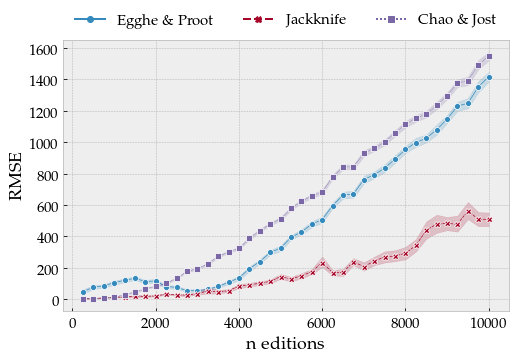

In [89]:
S_df['RMSE'] = np.sqrt((S_df['n editions'] - S_df['S']) ** 2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='n editions', y='RMSE', hue='estimator', data=S_df, 
             style='estimator', markers=True, linewidth=0.7)
legend_on_top(ax, 4)
plt.savefig('../reports/figures/estimator_comparison_variable_alpha.pdf')

Once we start having more realistic frequency distributions in which certain editions occur more often than others, the Jackknife estimator actually outperforms the other two. Let's dive a little deeper into the effect of sample size * number of editions ($S$). 

In [388]:
def rmse(pred, true):
    return np.sqrt((pred - true) ** 2)

n_experiments = 50
edition_sizes = np.arange(100, 10000, 100)
sample_sizes = np.arange(100, 20000, 100)
results = []
for _ in tqdm_notebook(list(range(n_experiments)), desc='experiment'):
    for size in tqdm_notebook(edition_sizes, desc='edition size', leave=False):
        for sample_size in tqdm_notebook(sample_sizes, desc='sample size', leave=False):
            # create a corpus with n editions, each having a run between 10 and 1000
            corpus = np.repeat(np.arange(size), np.random.randint(10, 1000, size))
            _, corpus_counts = np.unique(corpus, return_counts=True)
            # sample `sample_size` items from the corpus, assuming that editions with more
            # copies have a higher chance of survival
            sample = np.random.choice(
                size, size=sample_size, p=corpus_counts / corpus_counts.sum())
            # compute the counts
            _, counts = np.unique(sample, return_counts=True)
            # estimate
            results.append({'sample size': sample_size, 'edition size': size,
                            'RMSE': rmse(ep(counts, alpha), size), 'estimator': 'Egghe \& Proot'})
            results.append({'sample size': sample_size, 'edition size': size,
                            'RMSE': rmse(jackknife(counts)[0], size), 'estimator': 'Jackknife'})
            results.append({'sample size': sample_size, 'edition size': size,
                            'RMSE': rmse(chao_richness(counts), size), 'estimator': 'Chao \& Jost'})
S_df = pd.DataFrame(results)

KeyboardInterrupt: 

Let's do one final experiment, where we center the number or runs at 500, and sample runs following a laplace distribution:

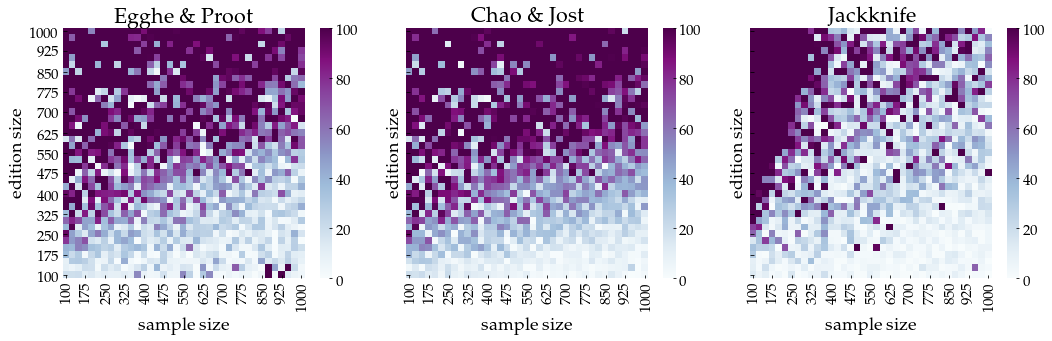

In [328]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True, sharex=True)
for i, estimator in enumerate(('Egghe \& Proot', 'Chao \& Jost', 'Jackknife')):
    r = S_df[S_df['estimator'] == estimator].groupby(
                ['edition size', 'sample size']).median().reset_index().pivot(
            "edition size", "sample size", "RMSE")
    sns.heatmap(r[::-1], cmap='BuPu', ax=axes[i], vmax=100)
    axes[i].set_title(estimator)
plt.tight_layout()

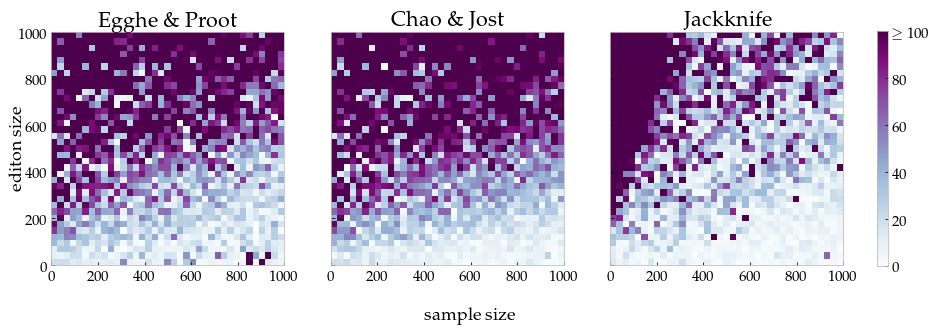

In [386]:
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True, sharex=True)
for i, estimator in enumerate(('Egghe \& Proot', 'Chao \& Jost', 'Jackknife')):
    r = S_df[S_df['estimator'] == estimator].groupby(
                ['edition size', 'sample size']).median().reset_index().pivot(
            "edition size", "sample size", "RMSE")
    im = axes[i].imshow(r[::-1], cmap='BuPu', vmax=100, extent=(0, 1000, 0, 1000), 
                   origin='upper')
    axes[i].set_title(estimator)
    axes[i].grid(b=None)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.014, pad=0.04,
                    ticks=[0, 20, 40, 60, 80, 100])
cbar.ax.set_yticklabels(['0', '20', '40', '60', '80', '$\geq$ 100'])
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("editon size")
plt.xlabel("sample size");

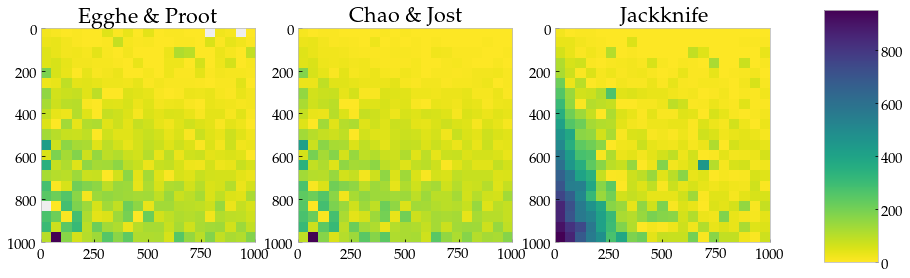

In [276]:
S_df['RMSE_n'] = S_df['RMSE'] / S_df['edition size']
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
rmse_min, rmse_max = 0, 1000
for i, estimator in enumerate(('Egghe \& Proot', 'Chao \& Jost', 'Jackknife')):
    im = axes[i].imshow(
        S_df[S_df['estimator'] == estimator].groupby(
            ['edition size', 'sample size'])['RMSE'].median().values.flatten().reshape(21,21),
        extent=(1000, 0, 1000, 0), cmap='viridis_r', origin='lower')
    axes[i].set_title(estimator)
    axes[i].grid(b=None)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [1267]:
# experiment with different numbers of editions
edition_sizes = np.array([200, 500, 1000, 2000, 5000, 10000])
sample_sizes = np.array([100, 500, 1000, 5000, 10000, 20000])
results = []
for _ in range(n_experiments):
    for size in edition_sizes:
        for sample_size in sample_sizes:
            # create a corpus with n editions, each having a run between 10 and 1000
            corpus = np.repeat(np.arange(size), np.clip(stats.dlaplace(0.01, loc=150).rvs(size), 10, 1e4).astype(int))
            _, corpus_counts = np.unique(corpus, return_counts=True)
            # sample `sample_size` items from the corpus, assuming that editions with more
            # copies have a higher chance of survival
            sample = np.random.choice(
                size, size=sample_size, p=corpus_counts / corpus_counts.sum())
            # compute the counts
            _, counts = np.unique(sample, return_counts=True)
            # estimate
            results.append({'sample size': sample_size, 'edition size': size,
                            'RMSE': rmse(ep(counts, alpha), size), 'estimator': 'Egghe & Proot'})
            results.append({'sample size': sample_size, 'edition size': size,
                            'RMSE': rmse(jackknife(counts)[0], size), 'estimator': 'Jackknife'})
            results.append({'sample size': sample_size, 'edition size': size,
                            'RMSE': rmse(chao_richness(counts), size), 'estimator': 'Chao & Jost'})
S_df = pd.DataFrame(results)

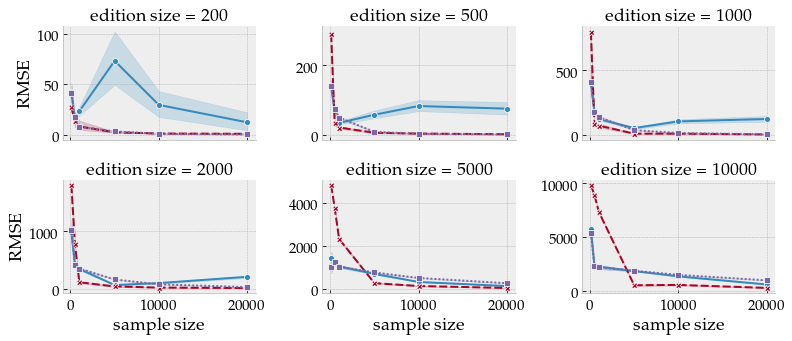

In [144]:
g = sns.FacetGrid(S_df, col="edition size", col_wrap=3, height=2.5, sharey=False, aspect=1.5)
g = (g.map_dataframe(
    sns.lineplot, "sample size", "RMSE", data=S_df, 
    hue='estimator', style='estimator', markers=True))
handles, labels = g.axes[-1].get_legend_handles_labels()
g.fig.legend(
        handles=handles[1:], labels=labels[1:],
        bbox_to_anchor=(0.0, 0.95, 1.0, 0.102),
        loc="upper center",
        ncol=3,
        borderaxespad=0.0,
        facecolor="white",
        framealpha=0,
        title=None);
plt.savefig("../reports/figures/estimator_comparison_variable_alpha_edition.pdf", bbox_inches='tight')

In [155]:
import numpy as np
import scipy.stats as stats
import seaborn as sns

np.random.lognormal(mean=4.5, sigma=1, size=1000).max()

2945.373932630796

In [157]:
np.exp(4.5)

90.01713130052181